In [1]:
#declarations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string
from tqdm import tqdm
from scipy import stats
warnings.filterwarnings('ignore')

Looking at the dataset, we have train.tsv and test.tsv files which are tab seperated values. We have seperate files for train and test so we will start exploring train.tsv file.

We can read tsv files using read_csv function of pandas by providing the correct delimeter: \t as shown below.

In [2]:
df = pd.read_csv("train.tsv",delimiter="\t")
df.drop('train_id',axis=1, inplace=True)
print("Shape of train datase:", df.shape)
df.head()

Shape of train datase: (1482535, 7)


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


We have 7 features and around 1.5M datapoints in the train dataset. Next we will look at the type of features.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482531 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 79.2+ MB


As we can see, we have 1 float feature containing continuous numericals. The feature is 'price' which is dependent variable we have to predict. It also has 2 integer features which contains discreet numericals. Looking at the non-null count we can say that there are null values in category_name, brand_name & item_description.

Next we will use describe() function in pandas which gives us info for the numerical columns. It will tell us various properties of all numerical features like count, mean, min, max etc.

In [4]:
df.describe()

,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06
mean,1.907380e+00,2.673752e+01,4.472744e-01
std,9.031586e-01,3.858607e+01,4.972124e-01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+01,0.000000e+00
50%,2.000000e+00,1.700000e+01,0.000000e+00
75%,3.000000e+00,2.900000e+01,1.000000e+00
max,5.000000e+00,2.009000e+03,1.000000e+00


Here we can see that the output feature 'Price' has a mean of 26.73 and median of 17.0 (50th percentile can be considered as median) which tells us that the dataset must contain Outliers which would result in high variation in mean and median. To further confirm this, we can see that there is a huge difference in 75th percentile value and max value which means that there would be some values which are really large. We will further look into this when we do analysis of each feature seperately.

Next we will check how many missing values we have in the dataset.

In [5]:
df.isnull().sum()

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [6]:
print("Null values in category_name feature: ", np.round(100*df.isnull().sum()['category_name']/df.shape[0], 4), "%")
print("Null values in brand_name feature: ", np.round(100*df.isnull().sum()['brand_name']/df.shape[0], 4), "%")
print("Null values in item_description feature: ", np.round(100*df.isnull().sum()['item_description']/df.shape[0], 4), "%")

Null values in category_name feature:  0.4268 %
Null values in brand_name feature:  42.6757 %
Null values in item_description feature:  0.0003 %


We have 6327 missing values in category_name and 632682 missing values in brand_name feature. We will look for the best ways to fill these missing values.

To get a visual representation of missing values, we will use seaborn's heatmap.

<AxesSubplot:>

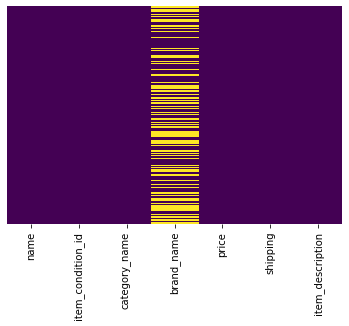

In [7]:
#checking for missing values 
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Above plot is a heatmap with the datapoints on Y-axis and different features on the X-axis. We can clearly see that brand_name feature has a lot of values missing but point to remember is that even though we have 6327 missing value in category_name feature and 4 missing value in item_description, it is not visible in the heatmap because of the large number of datapoints. 

Now we will look into each feature seperately.

# Price Feature - Analysis

We will plot the PDF of Price feature. 

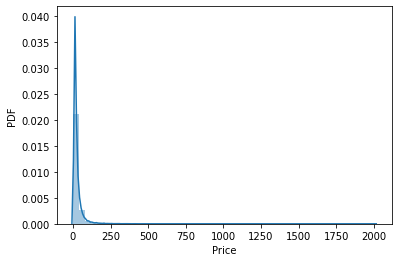

In [8]:
sns.distplot(df.price, bins=50).set(xlabel='Price', ylabel='PDF');

ABove is the PDF plot of our dependent feature 'price', We can see that the plot is skewed towards right and most of the value lies in the range $0-250. The distribution looks like a Log-Normal Distribution. 
A distribution is log-normal distribution when the log of values of the distribution follows a Normal distribution. To avoid error associated wiht Log(0), we will be taking Log(x+1) while transforming the price feature to Log-Normal distribution.

In [6]:
df["log_price"] = df.price.apply(lambda x:np.log(x+1))

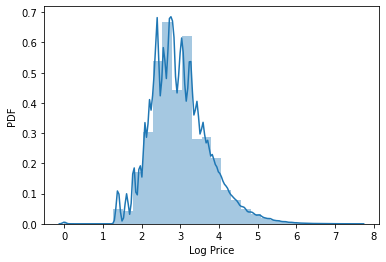

In [10]:
sns.distplot(df.log_price, bins=30).set(xlabel='Log Price', ylabel='PDF');

This distribution is close to Guassian Distribution and is more robust to outliers. We will get better results if we work with Log_Price featrue compared to the 'Price' feature we originally had.

Let's try to understand the skewness of the data, we will look into some of the products which are costly to understand if there is a pattern.

In [7]:
df[['name', 'price', 'brand_name']].sort_values('price', ascending=False).head(10)

,name,price,brand_name
760469,NEW Chanel WOC Caviar Gold Hardware,2009.0,Chanel
1262245,NEW-Chanel Boy Wallet o Chain WOC Caviar,2006.0,Chanel
1393600,David Yurman Wheaton ring,2004.0,David Yurman
742113,Chanel Chevron Fuschia Pink 2,2000.0,Chanel
956343,Chanel Black wallet on chain,2000.0,Chanel
1445348,Vs2/I 1ct Diamond Engagement Ring,2000.0,NaN
778940,Mary kay,2000.0,Mary Kay
415027,Chanel Classic Jumbo Single flap bag,2000.0,Chanel
1250053,Brand New Chanel CC Quilted WOC,2000.0,Chanel
952000,Chanel J12 H0682 Wrist Watch for Women,1999.0,NaN


One interesting thing to observe here is that we see Chanel brand in most of these products which tells us that this brand has costly products. Other common thing we see is the product 'ring' but of different brands which makes sense because a diamond ring costs a lot.  

From this we can say that the Outliers in the dataset are the high-valued items being sold on the website and hence we cannot simply drop the outlier points.

# Numerical Features - Analysis

# Item Condition id

In [12]:
df.item_condition_id.value_counts()

print("Percentage of points with Condition 1: NEW:", np.round(100*df.item_condition_id.value_counts()[1]/df.shape[0], 2), "%")
print("Percentage of points with Condition 2: LIKE NEW:", np.round(100*df.item_condition_id.value_counts()[2]/df.shape[0], 2), "%")
print("Percentage of points with Condition 3: GOOD:", np.round(100*df.item_condition_id.value_counts()[3]/df.shape[0], 2), "%")
print("Percentage of points with Condition 4: FAIR:", np.round(100*df.item_condition_id.value_counts()[4]/df.shape[0], 2), "%")
print("Percentage of points with Condition 5: POOR:", np.round(100*df.item_condition_id.value_counts()[5]/df.shape[0], 2), "%")

Percentage of points with Condition 1: NEW: 43.21 %
Percentage of points with Condition 2: LIKE NEW: 25.33 %
Percentage of points with Condition 3: GOOD: 29.15 %
Percentage of points with Condition 4: FAIR: 2.16 %
Percentage of points with Condition 5: POOR: 0.16 %


<AxesSubplot:xlabel='item_condition_id', ylabel='count'>

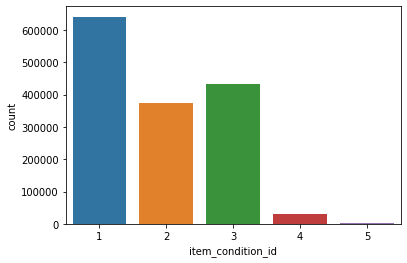

In [13]:
sns.countplot(x ='item_condition_id', data = df)

There is a huge data imbalance in the Item_condition_id feature. As we can see majority of the datapoints are for the condition_id: 1, 2 & 3 which tells us that sellers prefer to sell their product which are in good condition. There are only 2.16% of products being sold in Fair condition and 0.16% of products being sold at Poor condition. 

Next we will rely on the power of statistics to determine how useful the item_condition_id feature is in predicting the Price feature. When we have a categorical feature with more than 2 categories and another Numerical feature, we perform Anova test to find the P-value which helps us in finding the influence of the Categorical feature on Numerical featrue.

In [14]:
fvalue, pvalue = stats.f_oneway(df.log_price[df.item_condition_id == 1], df.log_price[df.item_condition_id == 2],
                                df.log_price[df.item_condition_id == 3], df.log_price[df.item_condition_id == 4], 
                                df.log_price[df.item_condition_id == 5])
print("P-Value for 'item_condition_id' feature is", pvalue)

P-Value for 'item_condition_id' feature is 3.782048627054952e-176


If p-value < 0.05, this means that the categorical variable has significant influence on the numerical variable.

Here, we are getting a very small p-value which means that the categorical feature item_condition_id is useful for predicting the price feature.

Bi-variate analysis between Item_Condition_id and Price

Text(6.799999999999997, 0.5, 'PDF')

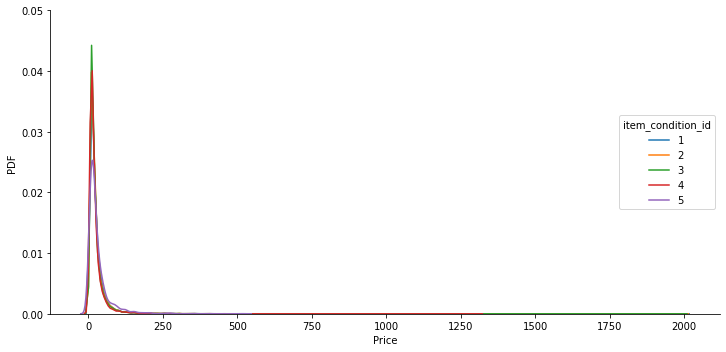

In [15]:
sns.FacetGrid(df, hue="item_condition_id", height =5, aspect=2, ylim=(0,0.05)).map(sns.distplot, "price", bins=30, hist=False);
plt.legend(title='item_condition_id', loc='right', labels=['1', '2', '3', '4', '5'])
plt.xlabel("Price")
plt.ylabel("PDF")

Text(6.799999999999997, 0.5, 'PDF')

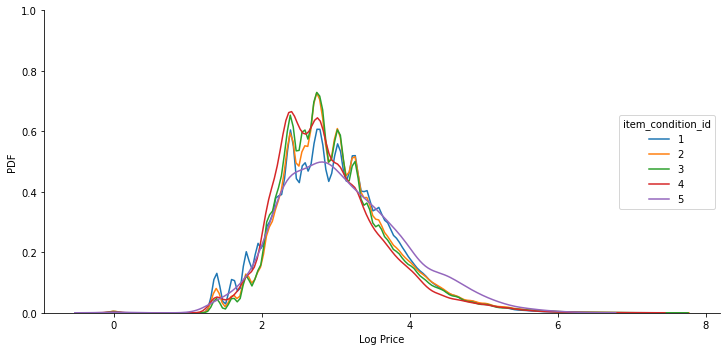

In [16]:
sns.FacetGrid(df, hue="item_condition_id", height =5, aspect=2, ylim=(0,1)).map(sns.distplot, "log_price", bins=30, hist=False);
plt.legend(title='item_condition_id', loc='right', labels=['1', '2', '3', '4', '5'])
plt.xlabel("Log Price")
plt.ylabel("PDF")

Compairing the above 2 plots we can clearly see that we get much better distribution while plotting PDF for Log Price, hence we will be using Log Price as the dependent feature for our model. From the above plot, we can see that while plotting PDF for Log price for various Item_Condition_ID, distribution for Item_Condition_ID 1 to 4 is very similar and distribution of category 5 is close as well. 

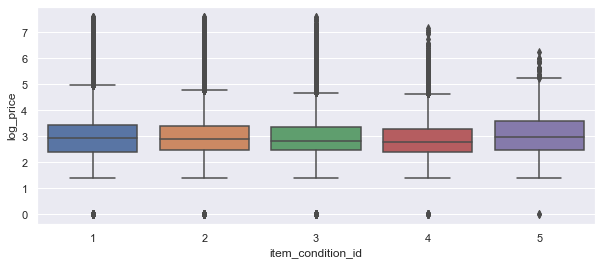

In [17]:
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(10,4)}) 
#The rc parameter of the function can be used to control the size of the final figure. 
#We will pass a dict as the value to this parameter with the key as figure.figsize and the required dimensions as the value.
sns.boxplot(x ='item_condition_id', y ='log_price', data = df);

We have a box plot between item_condition_id and Log_price values. The prices seems to be evenly distributed for various item_condition category. The Interquartile range and median price of condition 5 (POOR) is a bit higher than the other categories. This could be because condition 5 might have products whose original price is higher hence customers are willing to buy them even if they are in somewhat poor condition. 

# Shipping - Analysis

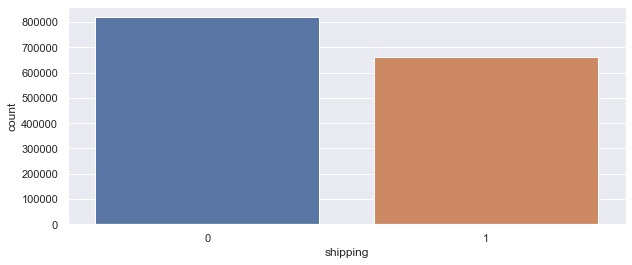

In [18]:
sns.countplot(x ='shipping', data = df);

In [19]:
df.shipping.value_counts()

print("Percentage of points with Shipping 0:", np.round(100*df.shipping.value_counts()[0]/df.shape[0], 2), "%")
print("Percentage of points with Shipping 1:", np.round(100*df.shipping.value_counts()[1]/df.shape[0], 2), "%")

Percentage of points with Shipping 0: 55.27 %
Percentage of points with Shipping 1: 44.73 %


Shipping: 0 represents shipping fees paid by buyer.

Shipping: 1 represents shipping fees paid by seller.

We can say that the data is balanced as we see good ratio between points iin both the categories.

To find the P-value we will perform the T-test as the feature has 2 categories and the other is numerical feature.

In [20]:
#Two-Sample T-Test
t_value, p_value=stats.ttest_ind(df.log_price[df.shipping == 0], df.log_price[df.shipping == 1])
print("P-Value for 'shipping' feature is", p_value)

P-Value for 'shipping' feature is 0.0


As we are getting P-value = 0.0, that means it will be a really small value since it is less than significant value. So we can say that the feature is useful for predicting the Price.

Bivariate

Text(8.96, 0.5, 'PDF')

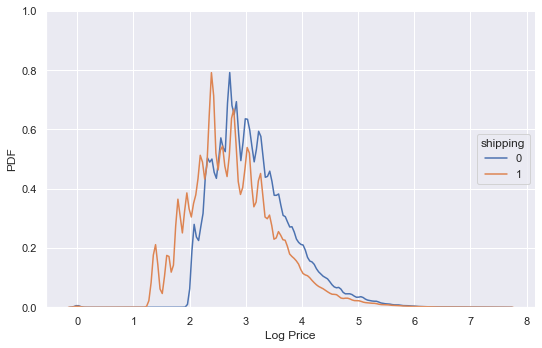

In [21]:
sns.FacetGrid(df, hue="shipping", height =5, aspect=1.5, ylim=(0,1)).map(sns.distplot, "log_price", bins=30, hist=False);
plt.legend(title='shipping', loc='right')
plt.xlabel("Log Price")
plt.ylabel("PDF")

From PDF of Log Price, we can see there is some difference in distribution when shipping is paid by user and seller.  From graph we can say that when Log_Price is less than 1.9, shipping is paid by seller.

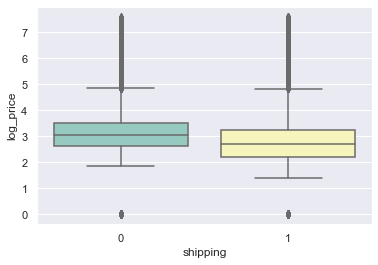

In [22]:
sns.set(rc = {'figure.figsize':(6,4)}) 
ax = sns.boxplot(x='shipping', y="log_price", data=df, palette="Set3")

Above is a box plot between different categories of shipping and Log_Price. From the above boxplot we can say that price range of category 1 is less than price range of category 0. 

# Name feature - Analysis

In [23]:
df.name.nunique()

1225273

As we can see we have 1.2M unique Product names out of total 1.5M products. We will look at some of the products with same names.

In [24]:
df.name.value_counts().head()

Bundle      2232
Reserved     453
Converse     445
BUNDLE       418
Dress        410
Name: name, dtype: int64

Bundle is a commonly used name which might represent a group of items being sold together, we can also see that Bundle and BUNDLE are considered different names here so we will handle this while doing data-preprocessing. 

In [123]:
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

names = ''

for sentence in tqdm(df.name):
    
    words = sentence.split(" ")
    for i in words:
        
        names += " ".join(words)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(names)

100%|█████████████████████████████████████████████████████████████████████| 1482535/1482535 [1:26:09<00:00, 286.76it/s]


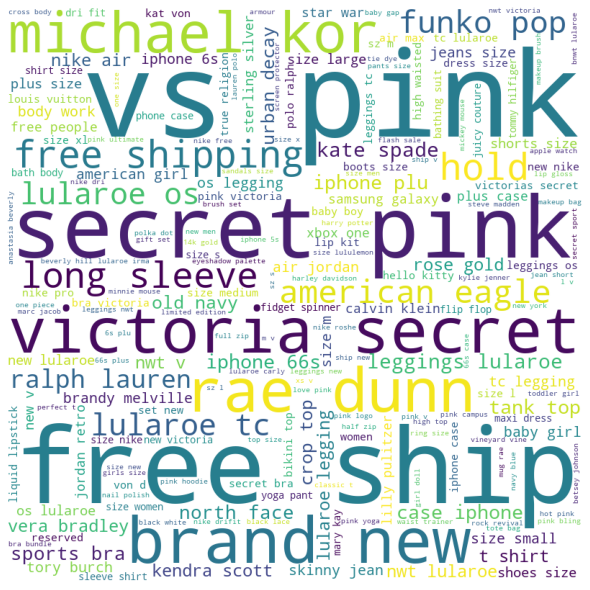

In [124]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Above is a word cloud for the words present in the 'name' column. The bigger the word in a word cloud is, higher is the frequency of the word. To get a better representation of the dataset, I have plotted this word cloud after cleaning the name feature for all rows.

Next we will see how prices of most frequent items vary, for this we will plot a bar plot of median of prices for the most occuring item names: 

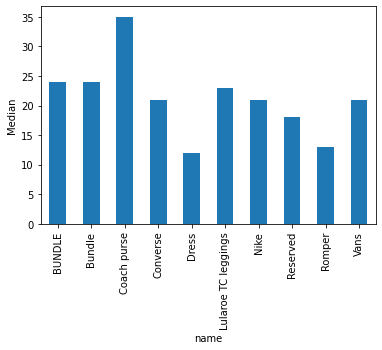

In [96]:
df[df['name'].isin(list(df.name.value_counts().index[:10]))].groupby('name')['price'].median().plot(\
    kind='bar', legend=False, ylabel = 'Median');

Above plot is the Median of prices of the items with the most frequently occuring names. We have various name values on the x-axis and their median price value on the y-axis.

# Description - Analysis

In [27]:
df.item_description.value_counts()[:10]

No description yet    82489
New                    4099
Brand new              3058
Good condition         1274
Great condition        1158
Like new                987
Never worn              837
NWT                     822
New with tags           644
Never used              605
Name: item_description, dtype: int64

We can see that there are a lot of datapoints with 'No Descrition Yet' as their description. This will be the default value provided by the website if the seller doesn't provide any description. So while missing value imputation we can give 'No Descrition Yet' to the products for which there is description is missing.

# Brand Name

In [8]:
print("Number of Missing values:", df.brand_name.isnull().sum())
print("Null values in brand_name feature: ", np.round(100*df.isnull().sum()['brand_name']/df.shape[0], 4), "%")

Number of Missing values: 632682
Null values in brand_name feature:  42.6757 %


In [9]:
df.brand_name.nunique()

4809

We have 4809 Unique Brand names and in the entire dataset we have 632683 missing values for Brand_name which is about 43% of the data. 

We will now look at some of the most and least common Brands.  

In [30]:
df.brand_name.value_counts().head(10)

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Name: brand_name, dtype: int64

In [31]:
df.brand_name.value_counts().tail(10)

Outset Media            1
ProTec                  1
Cecico                  1
SAS Safety Corp.        1
Gerber Childrenswear    1
Gaggia                  1
Super Sunglasses        1
Puffs                   1
Paul Jones              1
eshakti                 1
Name: brand_name, dtype: int64

This gives us some idea about how many items we have for each brand. To get a visual representation we will plot a graph whith item count for the top frequent brands. Some of the most popular brands being sold are Pink, Nike, Victoria's Secret etc while there are a lot of brands which are just sold once.

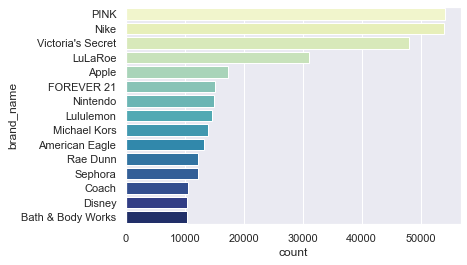

In [32]:
sns.countplot(data=df, y='brand_name', order=df['brand_name'].value_counts().index[:15], palette="YlGnBu");

We have plotted frequency of various brands in the dataset, Pink and Nike are the most common brands. (PINK is an apparel line by Victoria's Secret). We can notice that the count is declining exponentially.

Brand VS Price

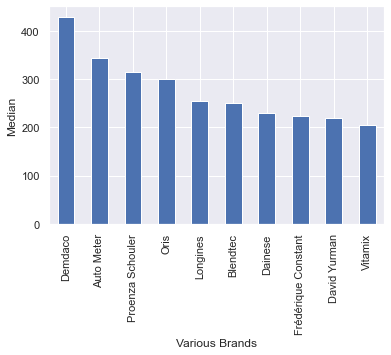

In [33]:
df.groupby('brand_name')['price'].median().sort_values(ascending=False).head(10).plot(\
    kind='bar', legend=False, ylabel = 'Median', xlabel = 'Various Brands');

At above plot we are looking at some of the most expensive brands. We have used Median value as a measure. Demdaco is the most expensive brand with median over 400$ followed by Auto Meter and others. To get a better look at the median values of various brands we will perform groupby and median.

In [106]:
df.groupby('brand_name')['price'].median().sort_values(ascending=False)

brand_name
demdaco                      429.0
auto meter                   344.0
proenza schouler             315.5
oris                         300.0
blendtec                     250.0
                             ...  
aa aquarium                    3.0
revlon colorsilk               3.0
twilight gypsy collective      3.0
cm style fashion               0.0
gossip girl                    0.0
Name: price, Length: 4800, dtype: float64

To understand more if Median can be used as a useful information, we will look at median value of prices for all brands. 

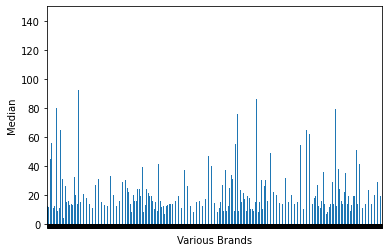

In [104]:
df.groupby('brand_name')['price'].median().plot(\
    kind='bar', legend=False, ylabel = 'Median', xlabel = 'Various Brands', ylim = (0,150)).set(xticklabels=[]);

When we plot a bar graph for median values of all Brands, we see some variablitiy in the various values. While doing feature engineering we will look if we can somehow use this information to create new features that will be useful for classification.

Filling missing Brand Name

In [10]:
print("Null values in brand_name feature: ", np.round(100*df.isnull().sum()['brand_name']/df.shape[0], 4), "%")

Null values in brand_name feature:  42.6757 %


To fill the missing value in Brand Name, we can fill all missing data with some default value or try to fill missing brand name using the data provided in other features. But we have to keep in mind that we don't provide the wrong data to the model or it can degrade the performance of the model.

As we saw while doing EDA for Name & Description feature, a lot of sellers have provided the name of the brand in Name or Derscrition columns. While it is easy to extract Brand name from Name column, we cannot completely rely on Description of the item to contain the correct Brand Name, so here we will only use Name of the item to check if it contains the brand name.

# Category

In [37]:
df.category_name.nunique()

1287

In [38]:
print("Number of Missing values: ", df.category_name.isnull().sum())
print("Null values in category_name feature: ", np.round(100*df.isnull().sum()['category_name']/df.shape[0], 4), "%")

Number of Missing values:  6327
Null values in category_name feature:  0.4268 %


We have 1287 unique categories and in the entire dataset we have 6327 datapoints with missing value for categories field which consitsts of around 0.4% of the total dataset.

We will now look at the most and least commonly occuring categories.

In [39]:
df.category_name.value_counts().head(10)

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64

In [40]:
df.category_name.value_counts().tail(10)

Handmade/Woodworking/Sports         1
Handmade/Holidays/St Patricks       1
Kids/Safety/Crib Netting            1
Home/Home Appliances/Dishwashers    1
Handmade/Children/Furniture         1
Handmade/Geekery/Housewares         1
Handmade/Patterns/Embroidery        1
Handmade/Paper Goods/Pad            1
Handmade/Glass/Vases                1
Handmade/Toys/Doll Clothes          1
Name: category_name, dtype: int64

From the first table it looks like Apparel, Makeup are very common choice of products sold at Mercari. 

One thing to notice is that there are a lot of products which will be common for Men & Women but since we the category column contains category and subcategory bot, we have a lot of variations of categories. 

Looking at the Mercari website there are a fewer categories and more sub-ctaegories in 2 levels. So it would be ideal to break our value into 3 columns. We will name them Category, Sub_Category_1, Sub_Category_1. 

In [11]:
df['Category'] = df.category_name.str.split('/', expand=True)[0]
df['Sub_Category_1'] = df.category_name.str.split('/', expand=True)[1]
df['Sub_Category_2'] = df.category_name.str.split('/', expand=True)[2]

In [42]:
print("No of categories in Category field:", df.Category.nunique())
print("No of categories in Sub Category 1 field:", df.Sub_Category_1.nunique())
print("No of categories in Sub Category 2 field:", df.Sub_Category_2.nunique())

No of categories in Category field: 10
No of categories in Sub Category 1 field: 113
No of categories in Sub Category 2 field: 870


<AxesSubplot:xlabel='Various Brands', ylabel='Count'>

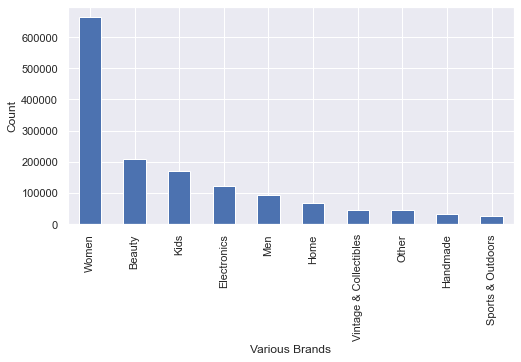

In [43]:
df.Category.value_counts().plot(kind='bar', legend=False, ylabel = 'Count', xlabel = 'Various Brands', figsize = (8,4))

Women is the most frequently occuring category for sellers to sell their products.  

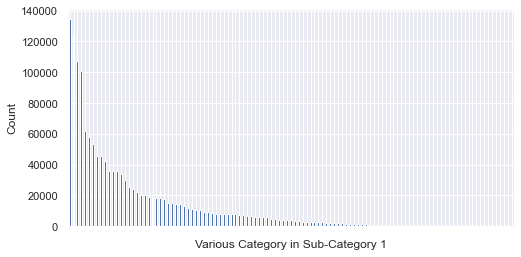

In [44]:
df.Sub_Category_1.value_counts().plot(kind='bar',legend=False, ylabel = 'Count', xlabel = 'Various Category in Sub-Category 1',\
                                  figsize = (8,4)).set(xticklabels=[]);

<AxesSubplot:xlabel='count', ylabel='Sub_Category_2'>

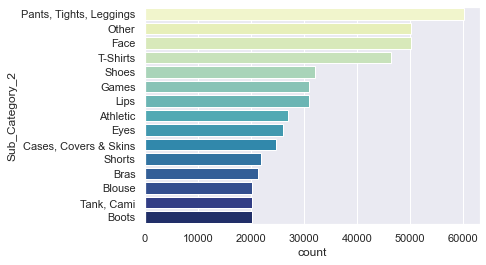

In [46]:
sns.countplot(data=df, y='Sub_Category_2', order=df['Sub_Category_2'].value_counts().index[:15], palette="YlGnBu")

Some of the most common sub_category_2 are appaeral items like Pants, T-shorts, shoes etc.

Category vs Price

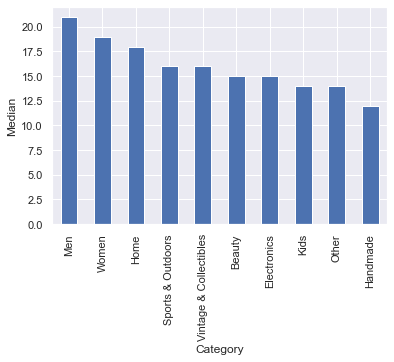

In [47]:
df.groupby('Category')['price'].median().sort_values(ascending=False).plot(kind='bar', legend=False, ylabel = 'Median', xlabel=None);

For the main category, Men's products have a higher price range than other categories.

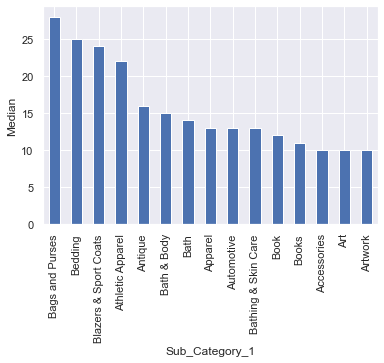

In [48]:
df.groupby('Sub_Category_1')['price'].median().head(15).sort_values(ascending=False).plot(\
    kind='bar', legend=False, ylabel = 'Median', xlabel=None);

For sub_category_1, Bags and Purses have the highest price range.

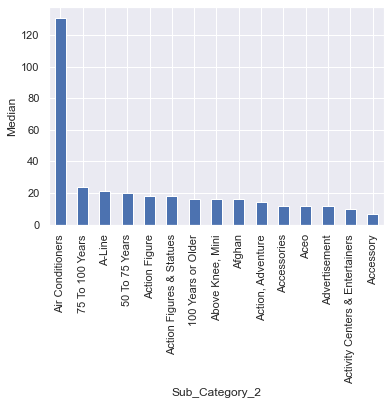

In [49]:
df.groupby('Sub_Category_2')['price'].median().head(15).sort_values(ascending=False).plot(\
    kind='bar', legend=False, ylabel = 'Median', xlabel=None);

For sub_category_2, air conditioners have the highest price range which is justifiable since AC's have a high cost. Also there's a huge difference between this category and other categories. 

# Data Pre-processing

Data preprocessing is a step where we transform the raw data in a useful and efficient format. 

We wil perform below steps in Data Preprocessing:

1. Missing Value Imputation
2. Clean text data

We will also look at various feature transformation techniques.

Missing value imputation: We have 4 datapoints with missing value for item_description, 6327 datapoints with missing value for category_name and 632682 datapoints with missing value for brand_name.

For item_description, we have seen that the default value provided by the value is 'No description yet' so we will add that value for the missing item description.

For category_name since we do not have enough information to fill the missing values I will go ahead with keeping the values as Null.

For Brand_name, we have a lot of missing values. From the EDA on item name, we can observe that a lot of sellers add brand name in the item name along with name of the product. We will try to extract the brand_names wherever we can to miss out some of the missing values. For the remaining values, we are going to go with 'missing' for imputation.


In [12]:
#Filling all missing data with some default values
df['item_description'].fillna('No description yet', inplace = True)
df['brand_name'].fillna('missing', inplace = True)
df['category_name'].fillna('missing/missing/missing', inplace = True)

Before we use item name to extract brand_name, we will clean the name and brand_name text data.

In [13]:
import nltk
from nltk.corpus import stopwords

def series_cleaning(series):
    '''function to clean text data'''
    
    series = series.apply(lambda x: x.lower())
    series = series.apply(lambda x: re.sub(r'[^\w\s]','',x))
    series = series.apply(lambda x: re.sub(' +',' ',x))
    
    return series

def text_cleaning(Input_Text):
    
    #if not pd.isnull(Input_Text)
    if len(Input_Text)>0:
        #decontractions
        Input_Text = re.sub(r"won't", "will not", Input_Text)
        Input_Text = re.sub(r"can\'t", "can not", Input_Text)

        Input_Text = re.sub(r"n\'t", " not", Input_Text)
        Input_Text = re.sub(r"\'re", " are", Input_Text)
        Input_Text = re.sub(r"\'s", " is", Input_Text)
        Input_Text = re.sub(r"\'d", " would", Input_Text)
        Input_Text = re.sub(r"\'ll", " will", Input_Text)
        Input_Text = re.sub(r"\'t", " not", Input_Text)
        Input_Text = re.sub(r"\'ve", " have", Input_Text)
        Input_Text = re.sub(r"\'m", " am", Input_Text)

        Input_Text = Input_Text.lower()
        Input_Text = re.sub(r'[^\w\s]','', Input_Text)
        Input_Text = re.sub(' +',' ', Input_Text)

    return Input_Text

def stopword_cleaning(Input_Text):
    
    Input_Text = text_cleaning(Input_Text)
    #stop word removal
    sw_list = stopwords.words('english')
    sw_list.remove('not')
    Input_Text =  " ".join([i for i in Input_Text.split() if i not in sw_list])
    
    return Input_Text

In [14]:
#cleaning Name
df['name'] = df['name'].apply(text_cleaning)

In [15]:
print("Unique item name after pre-processing Item Name: ", df.name.nunique())

Unique item name after pre-processing Item Name:  1119591


Using pre-processing we were able to decrease the unique names by 8%. This is good as we have less categories for the model to learn.

In [16]:
df.name.value_counts().head(10)

bundle                  3243
lularoe tc leggings     1135
reserved                 918
lularoe os leggings      905
coach purse              710
on hold                  706
miss me jeans            689
american eagle jeans     680
michael kors purse       568
michael kors wallet      497
Name: name, dtype: int64

In [17]:
#cleaning brand_name
df['brand_name'] = df['brand_name'].apply(text_cleaning)

In [18]:
print("Unique Brand_name after pre-processing: ", df.brand_name.nunique())

Unique Brand_name after pre-processing:  4800


We were able to correcrtly merge 9 brand_names. 

In [19]:
#get the list of existing brand names
brands = list(df.brand_name[df.brand_name != 'missing'].unique())

In [20]:
df.brand_name.value_counts()['missing']

632682

In [21]:
#we will create a dictionary to store the extracted brand name and the category they belong to
brand_dict = {}

for index, row in tqdm(df[['brand_name', 'category_name']].iterrows()):
    
    if row.brand_name != 'missing':
        
        if brand_dict.get(row.brand_name, -1) == -1:
            brand_dict[row.brand_name] = set()
            brand_dict[row.brand_name].add(str(row.category_name))
        else:
            brand_dict[row.brand_name].add(str(row.category_name))

1482535it [01:12, 20532.42it/s]


In [22]:
#now assigning brands to missing values 
count = 0 
for index, row in tqdm(df[['name','brand_name', 'category_name']].iterrows()):
    
    if row.brand_name == 'missing':
        
        for brand in brand_dict.keys():
    
            if brand.split(" ")[0] in row['name'].split():
                if brand in row['name'] and row['category_name'] in brand_dict[brand]:
                    count+=1
                    df.loc[index, ['brand_name']] = brand
#                    print(df.loc[index])
#    if count>5:break


print("missing values filled:",count)

1482535it [2:50:33, 144.87it/s]

missing values filled: 155014


In [24]:
print("Null values in brand_name feature: ", np.round(100*(632682-df[df.brand_name == 'missing'].shape[0])/632682, 4), "%")

Null values in brand_name feature:  23.1461 %


In [30]:
df.brand_name.value_counts()['missing']

486241

We were able to fill 155014 missing values in brand_name. This is around 23% of the missing data values which we were able to fill. 

In [25]:
#cleaning item desceiption
df['item_description'] = df['item_description'].apply(stopword_cleaning)

Next we will combine name and description before we perform other data-processing steps:

In [26]:
df['combined'] = df['name']+ " " + df['item_description']

Stemming

In [27]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

for index, sentence in df[['combined']].iterrows():
    new_sentence = ''   

    for word in sentence['combined'].split(" "):
        
        word = ps.stem(word)
        new_sentence += " "+ word
        
    new_sentence = re.sub(' +',' ',new_sentence)
    #series.apply(lambda x: re.sub(' +',' ',x))
    
    df.loc[index, ['combined']] = new_sentence.strip()


In [29]:
df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,Category,Sub_Category_1,Sub_Category_2,combined
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,mlb,10.0,1,description yet,2.397895,Men,Tops,T-shirts,mlb cincinnati red t shirt size xl descript yet
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,razer,52.0,0,keyboard great condition works like came box p...,3.970292,Electronics,Computers & Tablets,Components & Parts,razer blackwidow chroma keyboard keyboard grea...
2,avaviv blouse,1,Women/Tops & Blouses/Blouse,target,10.0,1,adorable top hint lace key hole back pale pink...,2.397895,Women,Tops & Blouses,Blouse,avaviv blous ador top hint lace key hole back ...
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,new tags leather horses retail rm stand foot h...,3.583519,Home,Home Décor,Home Décor Accents,leather hors statu new tag leather hors retail...
4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,complete certificate authenticity,3.806662,Women,Jewelry,Necklaces,24k gold plate rose complet certif authent


In [31]:
df.drop(['name', 'category_name', 'item_description', 'price'],axis=1, inplace=True)
df.head(20)

,item_condition_id,brand_name,shipping,log_price,Category,Sub_Category_1,Sub_Category_2,combined
0,3,mlb,1,2.397895,Men,Tops,T-shirts,mlb cincinnati red t shirt size xl descript yet
1,3,razer,0,3.970292,Electronics,Computers & Tablets,Components & Parts,razer blackwidow chroma keyboard keyboard grea...
2,1,target,1,2.397895,Women,Tops & Blouses,Blouse,avaviv blous ador top hint lace key hole back ...
3,1,missing,1,3.583519,Home,Home Décor,Home Décor Accents,leather hors statu new tag leather hors retail...
4,1,missing,0,3.806662,Women,Jewelry,Necklaces,24k gold plate rose complet certif authent
5,3,missing,0,4.094345,Women,Other,Other,bundl item request for ruie banana republ bott...
6,3,acacia swimwear,0,4.174387,Women,Swimwear,Two-Piece,acacia pacif tide santorini top size small str...
7,3,soffe,1,1.945910,Sports & Outdoors,Apparel,Girls,girl cheer and tumbl bundl of 7 get three pair...
8,3,nike,0,2.995732,Sports & Outdoors,Apparel,Girls,girl nike pro short girl size small plu green ...
9,3,missing,0,2.197225,Vintage & Collectibles,Collectibles,Doll,porcelain clown doll checker pant vtg realiz p...


In [33]:
df.to_csv("processed_31oct.csv")

In [34]:
df = pd.read_csv("processed_31oct.csv")
df2 = pd.read_csv("train.tsv",delimiter="\t")

Results after pre-processing

In [35]:
for i in range(20):
    if i>15:
        print(i+1)
        print(df2.loc[i, 'name'], df2.loc[i, 'item_description'], end='\n\n')
        print(df.loc[i, 'combined'], end='\n\n')

17
Glitter Eyeshadow 2 glitter eyeshadows; one in Brass and one in Bleached.

glitter eyeshadow 2 glitter eyeshadow one brass one bleach

18
New: Baby K'tan active baby carrier Brand new in box Size: Medium Color: Coral Retails for [rm] The Baby K’tan ACTIVE is made of a breathable hi-tech performance fabric that wicks away moisture and sweat, blocks over 90% of the sun’s harmful UVA and UVB rays, and provides a unique temperature control. - Ergonomic positioning for healthy infant development. - Evenly distributes weight across back and shoulders. - Double-loop design slips on like a t-shirt.

new babi k notan activ babi carrier brand new box size medium color coral retail rm babi ktan activ made breathabl hitech perform fabric wick away moistur sweat block 90 sun harm uva uvb ray provid uniqu temperatur control ergonom posit healthi infant develop evenli distribut weight across back shoulder doubleloop design slip like tshirt

19
Too Faced Limited "Merry Macaroons" This AUTHENTIC pal